In [1]:
# import libraries
import pandas as pd
import polars as pl
import numpy as np
import scipy.stats as stats


import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date

In [2]:
df = (
    pl.read_parquet('/Users/fredrik.hornell/Python/Private/Walmart_M5/data/interim/df_point_of_sale_adj.parquet')
)

print(df.sample(10))

shape: (10, 3)
┌─────────────────────────────────┬────────────┬───────┐
│ id                              ┆ date       ┆ sales │
│ ---                             ┆ ---        ┆ ---   │
│ str                             ┆ date       ┆ i16   │
╞═════════════════════════════════╪════════════╪═══════╡
│ FOODS_3_019_CA_3_evaluation     ┆ 2012-11-25 ┆ 4     │
│ HOUSEHOLD_2_254_WI_1_evaluatio… ┆ 2014-12-08 ┆ 0     │
│ HOUSEHOLD_2_131_WI_2_evaluatio… ┆ 2011-04-08 ┆ 0     │
│ HOUSEHOLD_2_357_WI_1_evaluatio… ┆ 2014-10-31 ┆ 0     │
│ HOBBIES_1_256_WI_1_evaluation   ┆ 2015-08-28 ┆ 1     │
│ FOODS_3_783_CA_3_evaluation     ┆ 2016-01-01 ┆ 0     │
│ HOBBIES_1_325_WI_3_evaluation   ┆ 2014-06-29 ┆ 0     │
│ HOUSEHOLD_1_163_TX_1_evaluatio… ┆ 2014-01-22 ┆ 0     │
│ FOODS_1_115_CA_3_evaluation     ┆ 2015-09-29 ┆ 1     │
│ FOODS_1_183_CA_4_evaluation     ┆ 2012-12-09 ┆ 2     │
└─────────────────────────────────┴────────────┴───────┘


In [6]:

df.filter(pl.col('id')=='FOODS_3_019_CA_3_evaluation').plot.line(x='date', y='sales')


:Curve   [date]   (sales)

In [7]:
df_test_id = (
    df
    .filter(pl.col('id')=='FOODS_3_019_CA_3_evaluation')
    .with_columns(pl.when(pl.col('sales') > 0).then(1).otherwise(0).alias('sales_ind'))
)

df_test_id

id,date,sales,sales_ind
str,date,i16,i32
"""FOODS_3_019_CA_3_evaluation""",2011-01-29,1,1
"""FOODS_3_019_CA_3_evaluation""",2011-01-30,3,1
"""FOODS_3_019_CA_3_evaluation""",2011-01-31,4,1
"""FOODS_3_019_CA_3_evaluation""",2011-02-01,4,1
"""FOODS_3_019_CA_3_evaluation""",2011-02-02,1,1
…,…,…,…
"""FOODS_3_019_CA_3_evaluation""",2016-05-18,2,1
"""FOODS_3_019_CA_3_evaluation""",2016-05-19,1,1
"""FOODS_3_019_CA_3_evaluation""",2016-05-20,2,1


In [18]:
list_of_ids = df.filter(pl.col('id')=='FOODS_3_019_CA_3_evaluation').to_series()

plot = (
    
    df
    # filter dataframe by id
    #.filter(pl.col('id').is_in(list_of_ids))
    .filter(pl.col('id')=='FOODS_3_019_CA_3_evaluation')

    # create new zero sales indicator column
    .select(pl.col('*'), pl.when(pl.col('sales') == 0).then(1).otherwise(0).alias('zero_sales_ind'))

    # create new delta column calulated from zero sales indicator continues periods
    .select(pl.col('*'), (pl.col('zero_sales_ind')- pl.col('zero_sales_ind').shift(1)).alias('delta'))

    # replace -1 with 0 otherwise delta column
    .select(pl.col('*').exclude('delta'), pl.when(pl.col('delta')==-1).then(0).otherwise(pl.col('delta')).alias('delta'))

    # calculate cumulative sum of delta column multiplied by zero sales indicator to get zero sales periods
    .select(pl.col('*'),(pl.col('delta').cumsum() * pl.col('zero_sales_ind')).alias('zero_sales_period'))
    
    # filter dataframe by zero sales indicator = 1 to get zero sales periods
    .filter(pl.col('zero_sales_ind')==1)
    

)

plot_agg_period = (
    plot
    # sum all consecuative days of zero sales
    .group_by('id','zero_sales_period').agg(pl.col('zero_sales_ind').sum().alias('nbr_zero_sales_in_a_row'))   
)
plot_agg_period


/var/folders/vg/gffx6m9j07j37nkdpql4hwr00000gq/T/ipykernel_20310/992393173.py:20: DeprecationWarning: `cumsum` is deprecated. It has been renamed to `cum_sum`.
  .select(pl.col('*'),(pl.col('delta').cumsum() * pl.col('zero_sales_ind')).alias('zero_sales_period'))


id,zero_sales_period,nbr_zero_sales_in_a_row
str,i32,i32
"""FOODS_3_019_CA_3_evaluation""",166,2
"""FOODS_3_019_CA_3_evaluation""",276,1
"""FOODS_3_019_CA_3_evaluation""",21,1
"""FOODS_3_019_CA_3_evaluation""",140,2
"""FOODS_3_019_CA_3_evaluation""",111,1
…,…,…
"""FOODS_3_019_CA_3_evaluation""",315,4
"""FOODS_3_019_CA_3_evaluation""",18,1
"""FOODS_3_019_CA_3_evaluation""",148,4


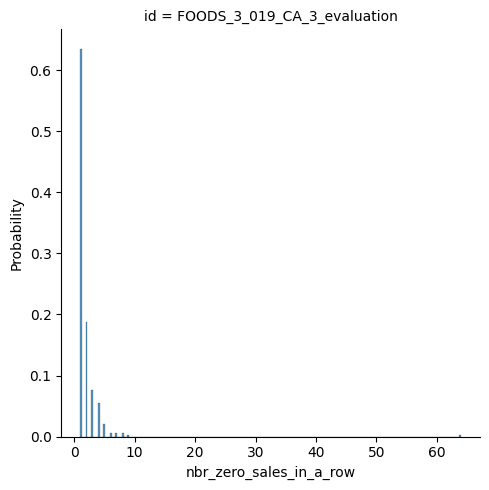

In [17]:
sns.displot(
    plot_agg_period.to_pandas()
    , x='nbr_zero_sales_in_a_row'
    , kind='hist'
    , stat='probability'
    , row = 'id'
    , common_bins = False

)

In [ ]:
import numpy as np
from scipy.stats import binom

def probability_of_x_ones_in_a_row(n, x, p):
    # n: length of the array
    # x: number of ones in a row
    # p: probability of getting a one in a single trial

    # Define the binomial distribution
    dist = binom(n=n, p=p)

    # Calculate the probability of getting exactly x ones in a row
    probability = dist.pmf(x)

    return probability

# Example usage:
array_length = 10  # replace with the actual length of your array
ones_in_a_row = 3  # replace with the desired number of ones in a row
probability_of_one = 0.5  # replace with the actual probability of getting a one in a single trial

result = probability_of_x_ones_in_a_row(array_length, ones_in_a_row, probability_of_one)
print(f"The probability of having {ones_in_a_row} ones in a row is: {result}")


The probability of having 3 ones in a row is: 0.1171875


In [ ]:
(
    df
    # filter dataframe by id
    #.filter(pl.col('id').is_in(list_of_ids))
    .filter(pl.col('id')=='HOUSEHOLD_2_007_TX_1_evaluation')

    # create new zero sales indicator column
    .select(pl.col('*'), pl.when(pl.col('sales') == 0).then(1).otherwise(0).alias('zero_sales_ind'))

    .select(
        pl.col('zero_sales_ind').mean().alias('mean_zero_sales_ind')
        , pl.col('zero_sales_ind').count().alias('count_zero_sales_ind')
    )

)


mean_zero_sales_ind,count_zero_sales_ind
f64,u32
0.909841,1697


zero_sales_period,nbr_zero_sales_in_a_row,OOS
i32,i32,i32
21,2,0
94,5,0
63,23,0
126,1,0
7,1,0
118,2,0
26,4,0
108,11,0
114,6,0


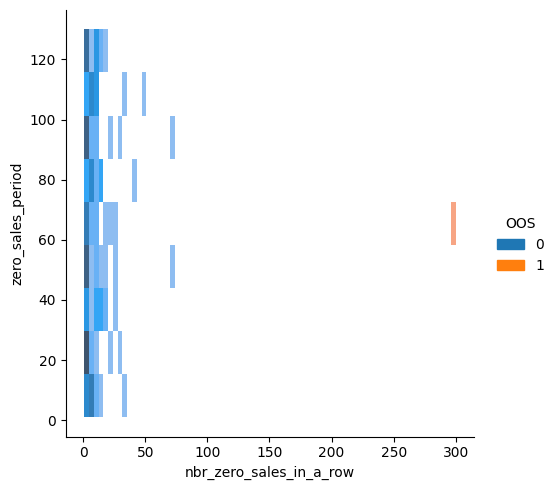

In [ ]:
plot_1 = plot_agg_period.select(
    pl.col('zero_sales_period')
    , pl.col('nbr_zero_sales_in_a_row')
    , pl.when(pl.col('nbr_zero_sales_in_a_row').map_elements(
        lambda x: probability_of_x_ones_in_a_row(x, x, 0.909841)  #0.840909
    )<= 0.001).then(1).otherwise(0).alias('OOS')
)

sns.displot(
    data = plot_1.to_pandas()
    , x = 'nbr_zero_sales_in_a_row'
    , y = 'zero_sales_period'
    #, kind = 'hist'
    #, stat = 'probability'
    , hue='OOS'
    #
)

plot_1

id,date,sales,OOS
str,date,i16,i32
"""HOUSEHOLD_2_00…",2011-09-30,1,0
"""HOUSEHOLD_2_00…",2011-10-01,0,0
"""HOUSEHOLD_2_00…",2011-10-02,1,0
"""HOUSEHOLD_2_00…",2011-10-03,1,0
"""HOUSEHOLD_2_00…",2011-10-04,0,0
"""HOUSEHOLD_2_00…",2011-10-05,0,0
"""HOUSEHOLD_2_00…",2011-10-06,0,0
"""HOUSEHOLD_2_00…",2011-10-07,0,0
"""HOUSEHOLD_2_00…",2011-10-08,0,0


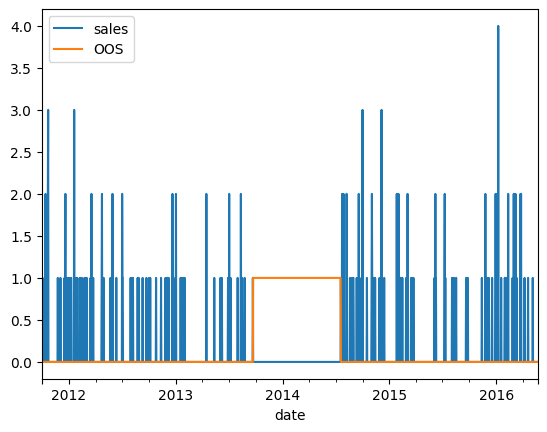

In [ ]:
join_1 = (
    plot
    .join(plot_1, on='zero_sales_period')
    .select([pl.col('id'), pl.col('date'), pl.col('OOS')])
)

df_plot_1= (
    df.filter(pl.col('id')=='HOUSEHOLD_2_007_TX_1_evaluation')
    .join(join_1, on=['id', 'date'] , how='left')
    .with_columns(pl.col('OOS').fill_null(strategy="zero").alias('OOS'))
)


df_plot_1.to_pandas().plot(x='date', y=['sales', 'OOS'])

df_plot_1

In [ ]:
# Finding out periods with zero sales that we should exclude

# step 1
# create zero sales indicator column

# step 2
# calculate zero sales periods dataframe

# step 3  
# calculate probability of  datapoint = 0 for whole dataset
# calculate number of datapoints in the dataset

# step 4 
# calculate the probability of each zero sales period given a binomial distribution
# with parameters from step 3
# set a threshold for the probability

# step 5 
# join the output from step 4 to the orignial dataframe 
# so we can filter out datapoints that belongs to zero sales periods that we deam to be low 

/tmp/ipykernel_130/2423461681.py:39: DeprecationWarning: `cumsum` is deprecated. It has been renamed to `cum_sum`.
  (pl.col('delta').cumsum().over('id') * pl.col('zero_sales_ind')).alias('zero_sales_period')


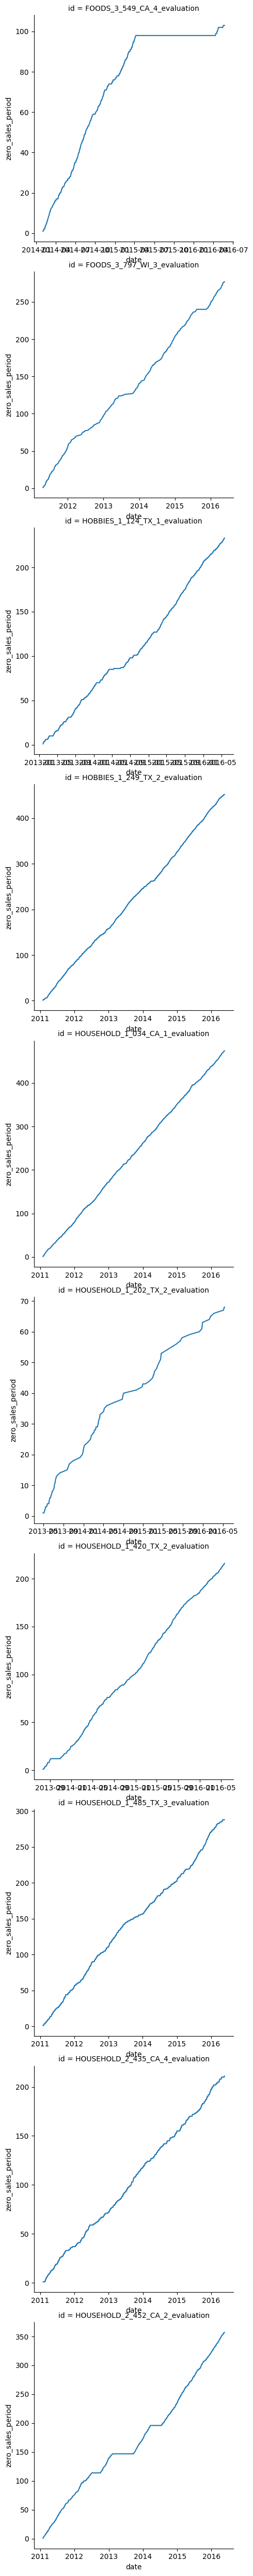

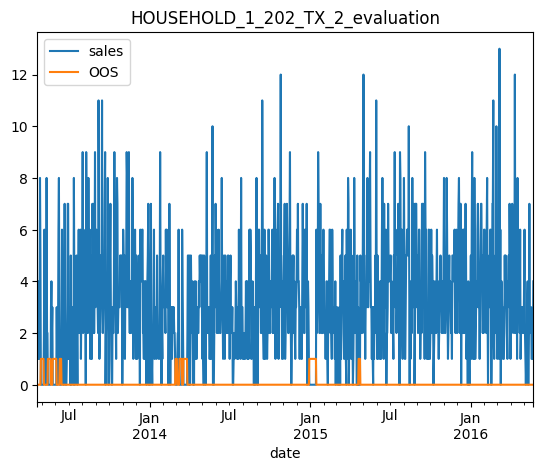

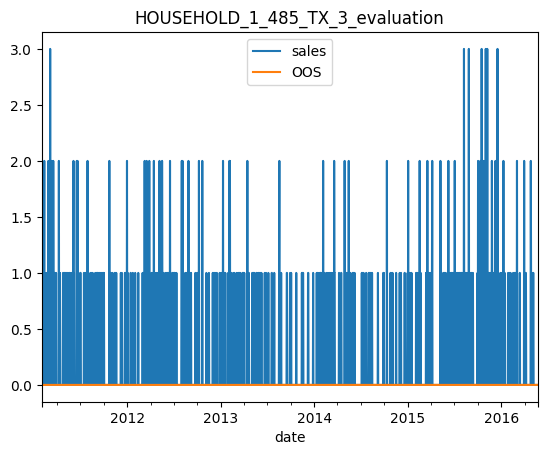

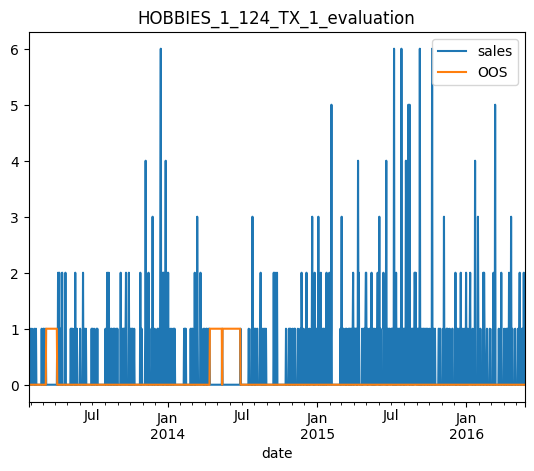

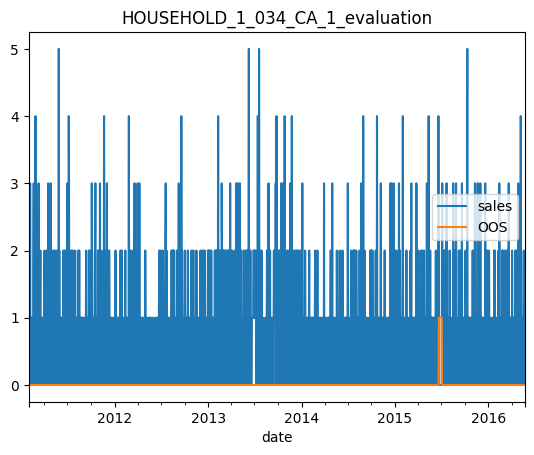

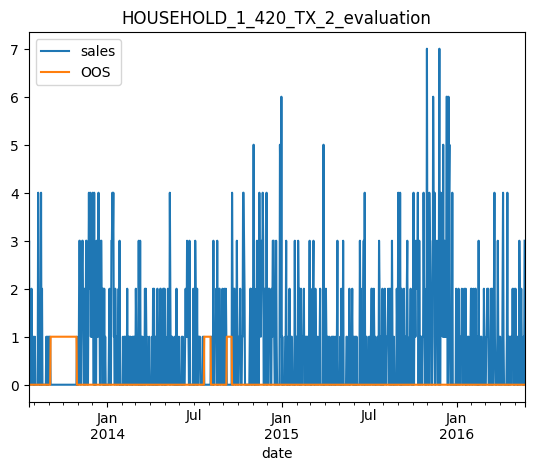

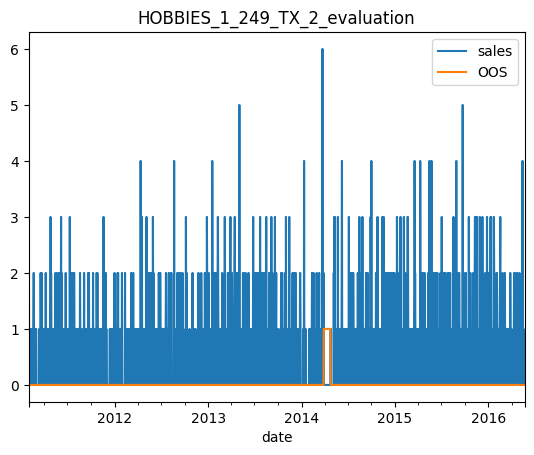

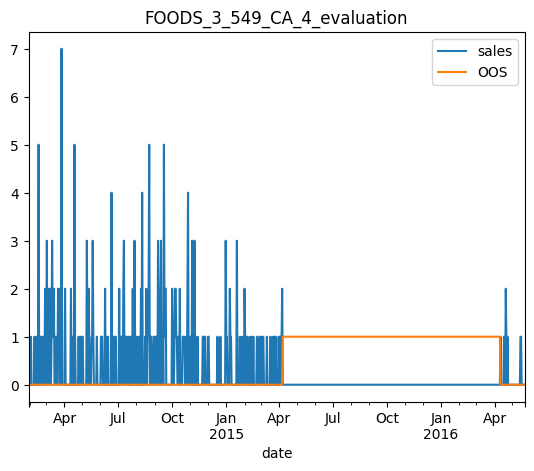

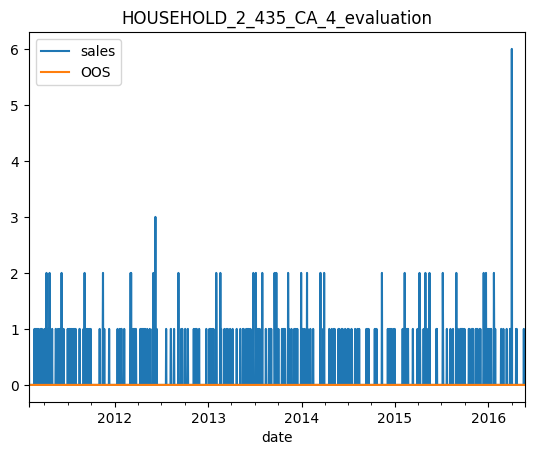

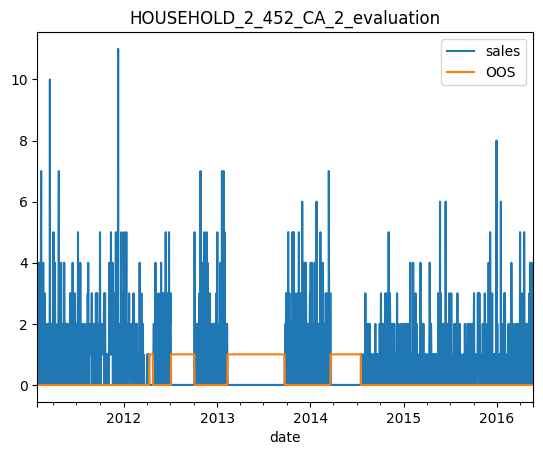

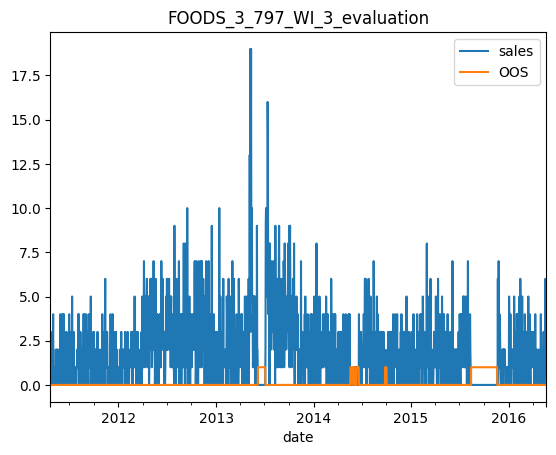

In [ ]:

list_of_ids = [
     'HOBBIES_1_264_WI_2_evaluation'
    , 'FOODS_3_687_CA_2_evaluation'
    , 'HOUSEHOLD_1_533_CA_2_evaluation'
    , 'FOODS_3_551_CA_1_evaluation'
    , 'HOUSEHOLD_2_007_TX_1_evaluation'
 ]


list_of_ids = df.select('id').sample(10).to_series()


df_zero_ind = (
    df.lazy()
    # filter dataframe by id
    .filter(pl.col('id').is_in(list_of_ids))
    .select(pl.col('*'), pl.when(pl.col('sales') == 0).then(1).otherwise(0).alias('zero_sales_ind'))

)


df_zero_sales_period = ( 
    df_zero_ind
    .sort(['id', 'date'])
    .select(
        pl.col('*'),
        (
            pl.col('zero_sales_ind') -
            pl.col('zero_sales_ind').shift(1).over('id')).alias('delta')
    )
    #
    .select(
            pl.col('*').exclude('delta'),
            pl.when(pl.col('delta')==-1).then(0).otherwise(pl.col('delta')).alias('delta')
        )
    # calculate zero sales periods and index them starting from 1 to n periods with consecutive zeros
    .select(
            pl.col('*'),
            (pl.col('delta').cumsum().over('id') * pl.col('zero_sales_ind')).alias('zero_sales_period')
        )
    .filter(pl.col('zero_sales_ind')==1)

)


df_zero_sales_probability = df_zero_ind.group_by('id').agg(pl.col('zero_sales_ind').mean().alias('prob_zero_sales'))



df_zero_sales_period_aggregated = (
    df_zero_sales_period
    .group_by('id','zero_sales_period').agg(pl.col('zero_sales_ind').sum().alias('nbr_zero_sales_in_a_row')) 
    .join(df_zero_sales_probability, on=['id'])
    .with_columns(
       pl.concat_list( pl.col('prob_zero_sales') ,pl.col('nbr_zero_sales_in_a_row')).alias('union')
    )
    # add a new column for the probability of each period in the dataset 
    # Count number of each period / total number of periods
    .with_columns(
        pl.when(
            pl.col('union').map_elements(
                lambda x: probability_of_x_ones_in_a_row(
                    n=x[1], x=x[1], p =x[0]
                    )
                ) <= 0.001
            ).then(1).otherwise(0).alias('OOS')
    )
)

join_1 = (
    df_zero_sales_period
    .join(df_zero_sales_period_aggregated, on=['id','zero_sales_period'])
    .select([pl.col('id'), pl.col('date'), pl.col('OOS')])
)

df_plot= (
    df_zero_ind 
    .join(# Join the calculated prob for the zero sales periods to 
            (  
                df_zero_sales_period
                .join(  # Join the calculated prob for the zero sales periods
                    df_zero_sales_period_aggregated
                    , on=['id','zero_sales_period']
                    )
                .select([pl.col('id'), pl.col('date'), pl.col('OOS')])
            )

            , on=['id', 'date'] 
            , how='left'
        )
    .with_columns(pl.col('OOS').fill_null(strategy="zero").alias('OOS'))
).collect()

# create new delta column calulated from zero sales indicator continues periods
#.select(pl.col('*'), (pl.col('zero_sales_ind')- pl.col('zero_sales_ind').shift(1)).alias('delta'))

# replace -1 with 0 otherwise delta column
#.select(pl.col('*').exclude('delta'), pl.when(pl.col('delta')==-1).then(0).otherwise(pl.col('delta')).alias('delta'))

# calculate cumulative sum of delta column multiplied by zero sales indicator to get zero sales periods
#.select(pl.col('*'),(pl.col('delta').cumsum() * pl.col('zero_sales_ind')).alias('zero_sales_period'))

# filter dataframe by zero sales indicator = 1 to get zero sales periods
#.filter(pl.col('zero_sales_ind')==1)
"""
sns.relplot(
    data=df_zero_sales_period.collect().to_pandas()
    , x='date'
    , y='zero_sales_period'
    , kind='line'
    , row='id'
    #, size='delta'
    , facet_kws={'sharey': False, 'sharex': False}
)

"""

for idx in list_of_ids:
    df_plot.filter(pl.col('id')==idx).to_pandas().plot(x='date', y=['sales','OOS'])
    plt.title(idx)



id,date,sales,zero_sales_ind,OOS
str,date,i16,i32,i32
"""HOUSEHOLD_2_00…",2011-09-30,1,0,0
"""HOUSEHOLD_2_00…",2011-10-01,0,1,0
"""HOUSEHOLD_2_00…",2011-10-02,1,0,0
"""HOUSEHOLD_2_00…",2011-10-03,1,0,0
"""HOUSEHOLD_2_00…",2011-10-04,0,1,0
"""HOUSEHOLD_2_00…",2011-10-05,0,1,0
"""HOUSEHOLD_2_00…",2011-10-06,0,1,0
"""HOUSEHOLD_2_00…",2011-10-07,0,1,0
"""HOUSEHOLD_2_00…",2011-10-08,0,1,0


In [ ]:
def calculate_zero_sales_periods(df, list_of_ids, binomial_threshold=0.001):
    """
    Calculate the probability that consecutive zero sales occur and classify  periods
    with a probability lower than the treshold as out of stock.

    Parameters:
    - df (polars.DataFrame): The input Polars DataFrame containing sales data.
    - list_of_ids (list): A list of IDs to filter the data. If None, all IDs are considered.
    - binomial_threshold (float, optional): The threshold for considering a period as out of stock.
      Defaults to 0.001.

    Returns:
    polars.LazyFrame: A lazy Polars DataFrame with information about zero sales periods and out of stock periods.

    Note: 
    The function assumes that 'pl' is an alias for the Polars library providing DataFrame operations.
    """


    # Creates a dataframe with zero sales indicator
    if list_of_ids is None:
        df_zero_ind = (df.lazy()
            .select(pl.col('*'), pl.when(pl.col('sales') == 0).then(1).otherwise(0).alias('zero_sales_ind'))
        )

    else:
        df_zero_ind = (df.lazy()
            .filter(pl.col('id').is_in(list_of_ids))
            .select(pl.col('*'), pl.when(pl.col('sales') == 0).then(1).otherwise(0).alias('zero_sales_ind'))
        )

    #  Creates a dataframe with zero sales periods
    df_zero_sales_period = ( 
        df_zero_ind
        .sort(['id', 'date'])
        # Calculate delta column between zero sales datapoints 
        .select(
            pl.col('*'),
            (
                pl.col('zero_sales_ind') -
                pl.col('zero_sales_ind').shift(1).over('id')).alias('delta')
        )
        # replace -1 with 0 because -1 is the same as 0 e.g a sales period 
        .select(
                pl.col('*').exclude('delta'),
                pl.when(pl.col('delta')==-1).then(0).otherwise(pl.col('delta')).alias('delta')
            )
        # cum_sum zero sales periods and index them starting from 1 to n periods with consecutive zeros
        .select(
                pl.col('*'),
                (pl.col('delta').cum_sum().over('id') * pl.col('zero_sales_ind')).alias('zero_sales_period')
            )
        .filter(pl.col('zero_sales_ind')==1)

    )
    
    # Create a dataframe with probability of zero sales based on total sales
    df_zero_sales_probability = (
        df_zero_ind.group_by('id')
        .agg(pl.col('zero_sales_ind')
        .mean().alias('prob_zero_sales'))
    )

    # Create a dataframe where each period of consecutive zeros is assigned a probability
    # if the probability of zero sales in a period is less than the threshold, then it is
    # considered as an out of stock period and is assigned a OOS value of 1 = flag
    df_zero_sales_period_aggregated = (
        df_zero_sales_period
        .group_by('id','zero_sales_period').agg(pl.col('zero_sales_ind').sum().alias('nbr_zero_sales_in_a_row')) 
        .join(df_zero_sales_probability, on=['id'])
        .with_columns(
            pl.concat_list( pl.col('prob_zero_sales') ,pl.col('nbr_zero_sales_in_a_row')).alias('union')
        )
        # add a new column for the probability of each period in the dataset 
        # Count number of each period / total number of periods
        .with_columns(
            pl.when(
                pl.col('union').map_elements(
                    lambda x: probability_of_x_ones_in_a_row(
                        n=x[1], x=x[1], p =x[0]
                        )
                    ) <= 0.001
                ).then(1).otherwise(0).alias('OOS')
        )
    )

    join_1 = (
        df_zero_sales_period
        .join(df_zero_sales_period_aggregated, on='zero_sales_period')
        .select([pl.col('id'), pl.col('date'), pl.col('OOS')])
    )

    df_with_OOS= (
        df_zero_ind
        .join(join_1, on=['id', 'date'] , how='left')
        .with_columns(pl.col('OOS').fill_null(strategy="zero").alias('OOS'))
    )

    join_1 = None
    df_zero_sales_period = None
    df_zero_sales_probability = None
    df_zero_sales_period_aggregated = None

    return  df_with_OOS

In [ ]:

list_of_ids = df.select('id').sample(100).to_series()

df_with_OOS = calculate_zero_sales_periods(df, list_of_ids=list_of_ids, binomial_threshold=0.001)

df_with_OOS.collect()

id,date,sales,zero_sales_ind,OOS
str,date,i16,i32,i32
"""HOUSEHOLD_1_19…",2011-01-29,3,0,0
"""HOUSEHOLD_1_35…",2011-01-29,1,0,0
"""HOUSEHOLD_2_37…",2011-01-29,4,0,0
"""HOBBIES_1_086_…",2011-01-29,3,0,0
"""HOUSEHOLD_1_46…",2011-01-29,1,0,0
"""FOODS_3_219_CA…",2011-01-29,32,0,0
"""FOODS_3_672_CA…",2011-01-29,2,0,0
"""HOBBIES_1_159_…",2011-01-29,5,0,0
"""HOBBIES_1_194_…",2011-01-29,2,0,0


In [ ]:
    """
    :param df: polars dataframe
    :param list_of_ids: if you want to calculate the periods for a subset of ids
    :param binomial_threshold: threshold for excluding  nbr of zero sales in a row e.g a zero sales period
    :return: 
    Finding out periods with zero sales that we should exclude

    step 1
    create zero sales indicator column

    step 2
    calculate zero sales periods dataframe

    step 3  
    calculate probability of  datapoint = 0 for whole dataset
    calculate number of datapoints in the dataset

    step 4 
    calculate the probability of each zero sales period given a binomial distribution
    with parameters from step 3
    set a threshold for the probability

    step 5 
    join the output from step 4 to the orignial dataframe 
    so we can filter out datapoints that belongs to unprobable zero sales periods    

    """

In [ ]:
import math

def binomial_distribution(k, n, p):
    """
    Calculate the probability of getting exactly k successes in n trials
    given the probability of success in each trial.

    Parameters:
    - k: Number of successes.
    - n: Number of trials.
    - p: Probability of success in each trial.

    Returns:
    - The probability of getting exactly k successes in n trials.
    """
    # Calculate the binomial coefficient: C(n, k)
    binomial_coefficient = math.comb(n, k)
    
    # Calculate the probability using the binomial PMF formula
    probability = binomial_coefficient * (p ** k) * ((1 - p) ** (n - k))
    
    return probability ,binomial_coefficient

# Example usage:
n_trials = 10  # Number of trials
p_success = 0.2  # Probability of success in each trial
k_successes = 10  # Number of successes

# Calculate the probability of getting exactly k successes
probability, binomial_coefficient = binomial_distribution(k_successes, n_trials, p_success)
print(f"Probability of getting exactly {k_successes} successes: {probability} and binomial coefficient {binomial_coefficient}")


Probability of getting exactly 10 successes: 1.0240000000000006e-07 and binomial coefficient 1


In [ ]:
import polars as pl


In [ ]:
(
    pl.DataFrame(
        {
            'id': ['id_1', 'id_2', 'id_3'],
            'period': [2, 5, 6],
            'probability': [0.1, 0.2, 0.3]
        }
    )
    .with_columns(
        int_range = pl.int_ranges(1, pl.col('period') + 1)
    )
    .explode(
         'int_range'
    )
    .with_columns(
        pl.col('int_range').cum_prod().over(['id']).alias('cum_prod')
    )
    # if period is not equal to draws then we dont need to calculat the factorial/ bionomial coefficient
    .group_by(['id', 'period', 'probability'])
    .agg(
        pl.col('cum_prod').max().alias('factorial')
    )
    .with_columns(
        (
            pl.col('probability') ** pl.col('period') * (1 - pl.col('probability')) ** (pl.col('period') - pl.col('period'))
        ).alias('likelihood')
        
    )

)

id,period,probability,factorial,likelihood
str,i64,f64,i64,f64
"""id_3""",6,0.3,720,0.000729
"""id_1""",2,0.1,2,0.01
"""id_2""",5,0.2,120,0.00032


In [ ]:
df = pl.DataFrame(
        {
            'id': ['id_1', 'id_2', 'id_3'],
            'target': [2, 5, 6],
            'probability': [0.1, 0.2, 0.3],
            'draws' : [2, 8, 10]
            
            
        }
)

entity_col, time_col = df.columns[:2]

In [ ]:
def calculate_binomal_prob_oos(df):

    entity_col, period_col, prob_col , draws_col = df.columns[:4]

    df_oos = (
        df
        .with_columns(

            factorial_range_target = pl.int_ranges(1, pl.col(perid_col) + 1)
            , factorial_range_draws = pl.int_ranges(1, pl.col(draws_col) + 1)
        )
        .explode('factorial_range')
        .with_columns(

            pl.col('factorial_range').cum_prod().over([entity_col]).alias('cum_prod')

        )
    )
    return df_oos

In [ ]:
entity_col, period_col, prob_col , draws_col = df.columns[:4]

(
    df
    .with_columns(

        factorial_range_target = pl.int_ranges(1, pl.col(period_col) + 1)
    )
    .explode(['factorial_range_target'])
    .with_columns(

        pl.col('factorial_range_target').cum_prod().over([entity_col]).alias('cum_prod_target')

    )
    .group_by([entity_col, period_col, prob_col , draws_col])
    .agg(
        pl.col('cum_prod_target').max().alias('factorial')
    )
    
)

id,target,probability,draws,factorial
str,i64,f64,i64,i64
"""id_1""",2,0.1,2,2
"""id_2""",5,0.2,8,120
"""id_3""",6,0.3,10,720


In [ ]:
df.columns[:4]

['id', 'target', 'probability', 'draws']

/tmp/ipykernel_136/769382586.py:39: DeprecationWarning: `cumsum` is deprecated. It has been renamed to `cum_sum`.
  (pl.col('delta').cumsum().over('id') * pl.col('zero_sales_ind')).alias('zero_sales_period')


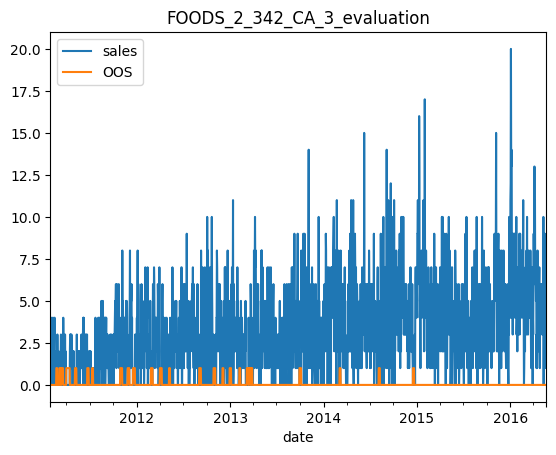

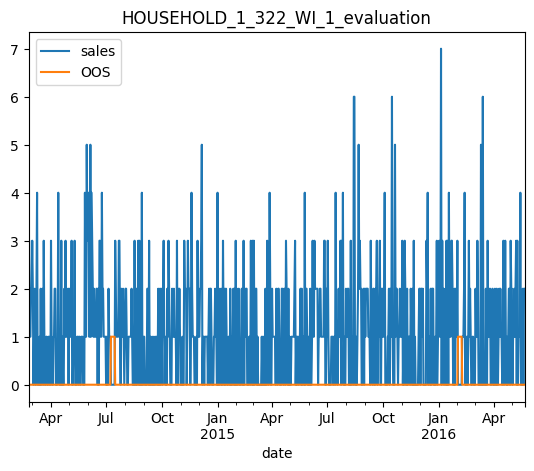

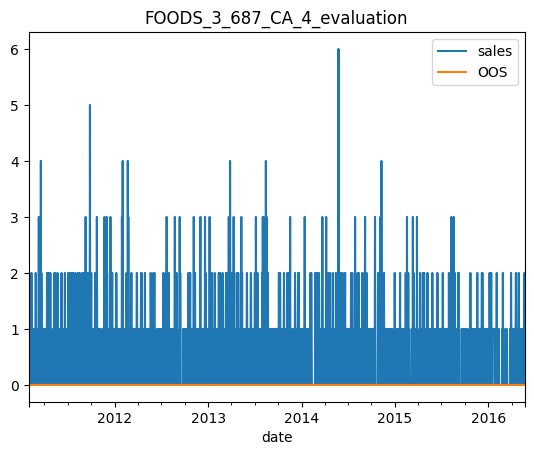

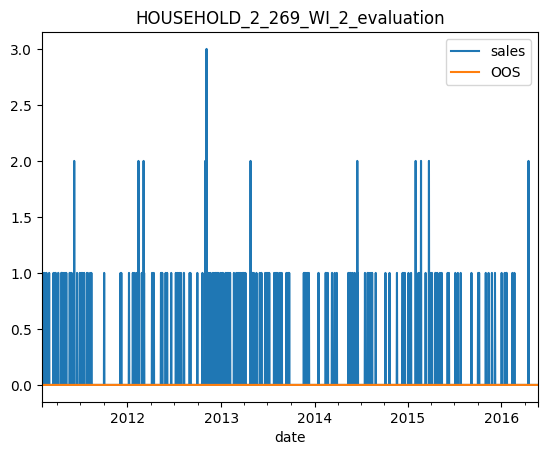

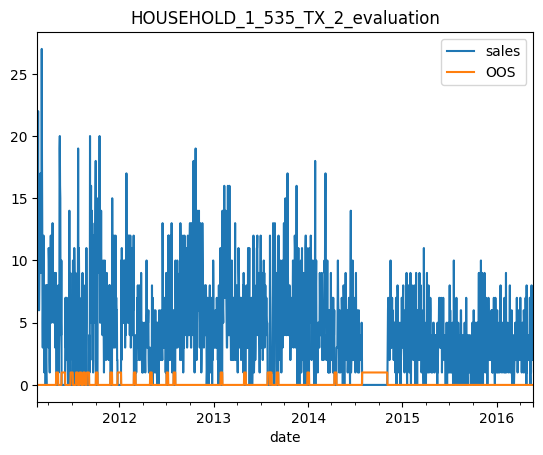

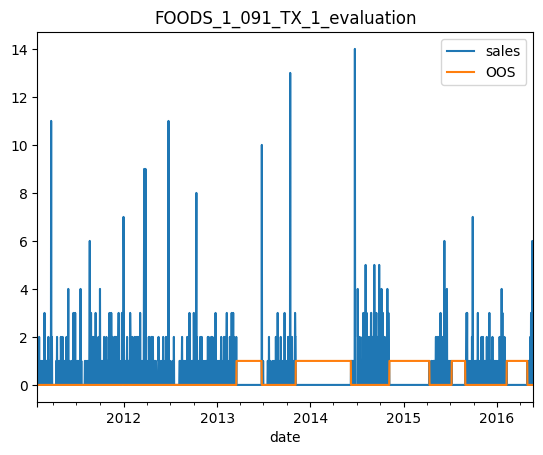

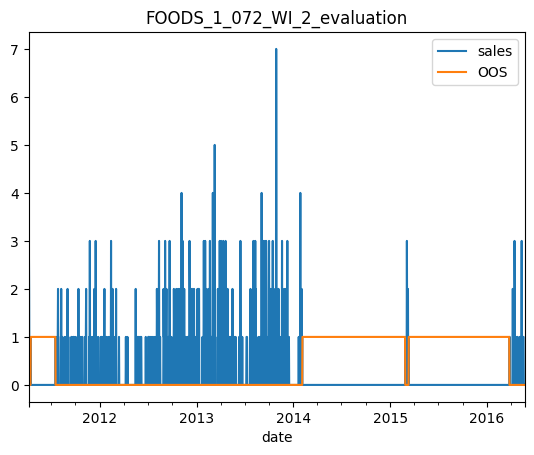

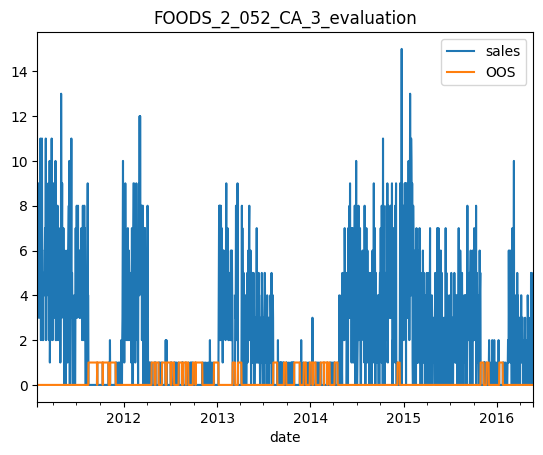

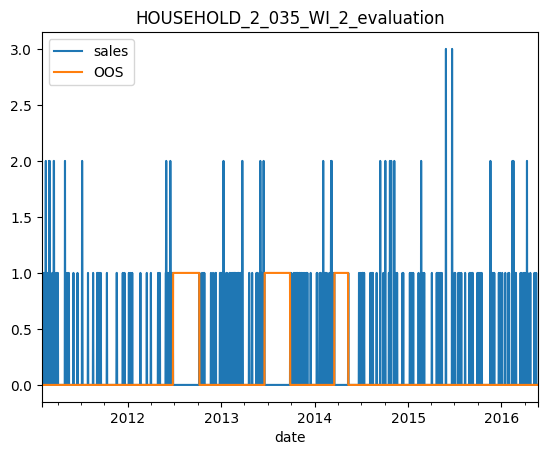

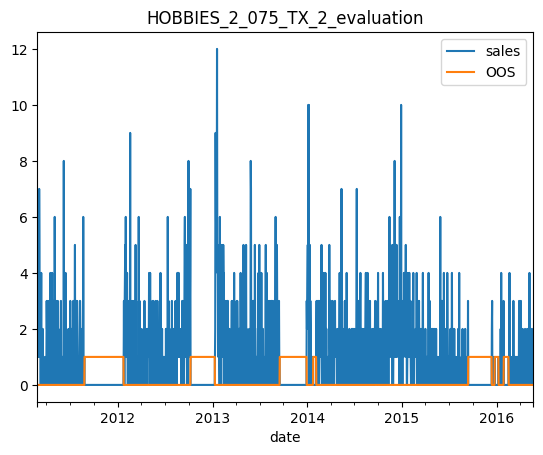

In [ ]:

list_of_ids = [
     'HOBBIES_1_264_WI_2_evaluation'
    , 'FOODS_3_687_CA_2_evaluation'
    , 'HOUSEHOLD_1_533_CA_2_evaluation'
    , 'FOODS_3_551_CA_1_evaluation'
    , 'HOUSEHOLD_2_007_TX_1_evaluation'
 ]


list_of_ids = df.select('id').sample(10).to_series()


df_zero_ind = (
    df.lazy()
    # filter dataframe by id
    .filter(pl.col('id').is_in(list_of_ids))
    .select(pl.col('*'), pl.when(pl.col('sales') == 0).then(1).otherwise(0).alias('zero_sales_ind'))

)


df_zero_sales_period = ( 
    df_zero_ind
    .sort(['id', 'date'])
    .select(
        pl.col('*'),
        (
            pl.col('zero_sales_ind') -
            pl.col('zero_sales_ind').shift(1).over('id')).alias('delta')
    )
    #
    .select(
            pl.col('*').exclude('delta'),
            pl.when(pl.col('delta')==-1).then(0).otherwise(pl.col('delta')).alias('delta')
        )
    # calculate zero sales periods and index them starting from 1 to n periods with consecutive zeros
    .select(
            pl.col('*'),
            (pl.col('delta').cumsum().over('id') * pl.col('zero_sales_ind')).alias('zero_sales_period')
        )
    .filter(pl.col('zero_sales_ind')==1)

)


df_zero_sales_probability = df_zero_ind.group_by('id').agg(pl.col('zero_sales_ind').mean().alias('prob_zero_sales'))



df_zero_sales_period_aggregated = (
    df_zero_sales_period
    .group_by('id','zero_sales_period').agg(pl.col('zero_sales_ind').sum().alias('nbr_zero_sales_in_a_row')) 
    .join(df_zero_sales_probability, on=['id'])
    .with_columns(
       pl.concat_list( pl.col('prob_zero_sales') ,pl.col('nbr_zero_sales_in_a_row')).alias('union')
    )
    # add a new column for the probability of each period in the dataset 
    # Count number of each period / total number of periods
    .with_columns(
        pl.when(
            pl.col('union').map_elements(
                lambda x: probability_of_x_ones_in_a_row(
                    n=x[1], x=x[1], p =x[0]
                    )
                ) <= 0.001
            ).then(1).otherwise(0).alias('OOS')
    )
)

join_1 = (
    df_zero_sales_period
    .join(df_zero_sales_period_aggregated, on=['id','zero_sales_period'])
    .select([pl.col('id'), pl.col('date'), pl.col('OOS')])
)

df_plot= (
    df_zero_ind 
    .join(# Join the calculated prob for the zero sales periods to 
            (  
                df_zero_sales_period
                .join(  # Join the calculated prob for the zero sales periods
                    df_zero_sales_period_aggregated
                    , on=['id','zero_sales_period']
                    )
                .select([pl.col('id'), pl.col('date'), pl.col('OOS')])
            )

            , on=['id', 'date'] 
            , how='left'
        )
    .with_columns(pl.col('OOS').fill_null(strategy="zero").alias('OOS'))
).collect()

# create new delta column calulated from zero sales indicator continues periods
#.select(pl.col('*'), (pl.col('zero_sales_ind')- pl.col('zero_sales_ind').shift(1)).alias('delta'))

# replace -1 with 0 otherwise delta column
#.select(pl.col('*').exclude('delta'), pl.when(pl.col('delta')==-1).then(0).otherwise(pl.col('delta')).alias('delta'))

# calculate cumulative sum of delta column multiplied by zero sales indicator to get zero sales periods
#.select(pl.col('*'),(pl.col('delta').cumsum() * pl.col('zero_sales_ind')).alias('zero_sales_period'))

# filter dataframe by zero sales indicator = 1 to get zero sales periods
#.filter(pl.col('zero_sales_ind')==1)
"""
sns.relplot(
    data=df_zero_sales_period.collect().to_pandas()
    , x='date'
    , y='zero_sales_period'
    , kind='line'
    , row='id'
    #, size='delta'
    , facet_kws={'sharey': False, 'sharex': False}
)

"""

for idx in list_of_ids:
    df_plot.filter(pl.col('id')==idx).to_pandas().plot(x='date', y=['sales','OOS'])
    plt.title(idx)


In [ ]:
df_zero_sales_probability.collect()

id,prob_zero_sales
str,f64
"""HOBBIES_2_075_…",0.562173
"""HOUSEHOLD_1_53…",0.173777
"""HOUSEHOLD_2_03…",0.875837
"""FOODS_3_687_CA…",0.621844
"""FOODS_1_091_TX…",0.73931
"""HOUSEHOLD_2_26…",0.898401
"""FOODS_1_072_WI…",0.846688
"""FOODS_2_342_CA…",0.170531
"""HOUSEHOLD_1_32…",0.363415


In [ ]:
df_zero_sales_period.collect()

id,date,sales,zero_sales_ind,delta,zero_sales_period
str,date,i16,i32,i32,i32
"""FOODS_1_072_WI…",2011-04-11,0,1,1,1
"""FOODS_1_072_WI…",2011-04-12,0,1,0,1
"""FOODS_1_072_WI…",2011-04-13,0,1,0,1
"""FOODS_1_072_WI…",2011-04-14,0,1,0,1
"""FOODS_1_072_WI…",2011-04-16,0,1,1,2
"""FOODS_1_072_WI…",2011-04-17,0,1,0,2
"""FOODS_1_072_WI…",2011-04-18,0,1,0,2
"""FOODS_1_072_WI…",2011-04-19,0,1,0,2
"""FOODS_1_072_WI…",2011-04-20,0,1,0,2


In [ ]:
df_zero_sales_period_aggregated =(
    df_zero_sales_period
    .group_by('id','zero_sales_period').agg(pl.col('zero_sales_ind').sum().alias('nbr_zero_sales_in_a_row')) 
    .join(df_zero_sales_probability, on=['id'])
    .with_columns(
        pl.when(
            (
                pl.col('prob_zero_sales') ** pl.col('nbr_zero_sales_in_a_row') * (1 - pl.col('prob_zero_sales')) ** (pl.col('nbr_zero_sales_in_a_row') - pl.col('nbr_zero_sales_in_a_row'))
            ) <= 0.001
        ).then(1).otherwise(0).alias('OOS')
    )
)
df_zero_sales_period_aggregated

<LazyFrame [5 cols, {"id": Utf8 … "OOS": Int32}] at 0x7F2227566970>

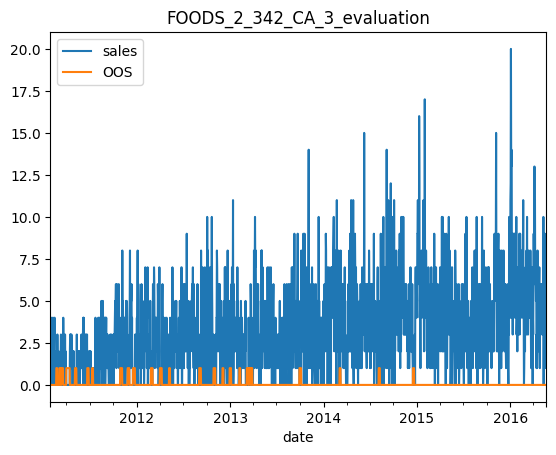

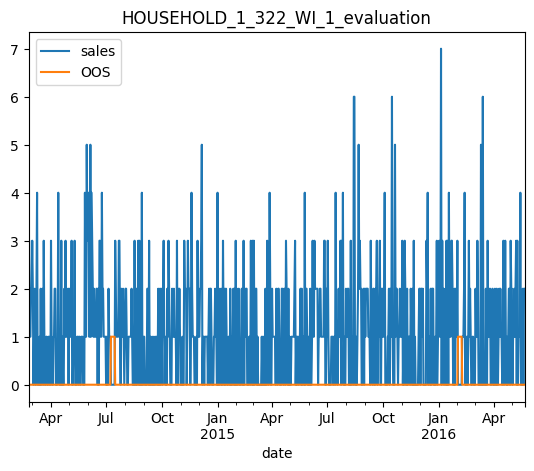

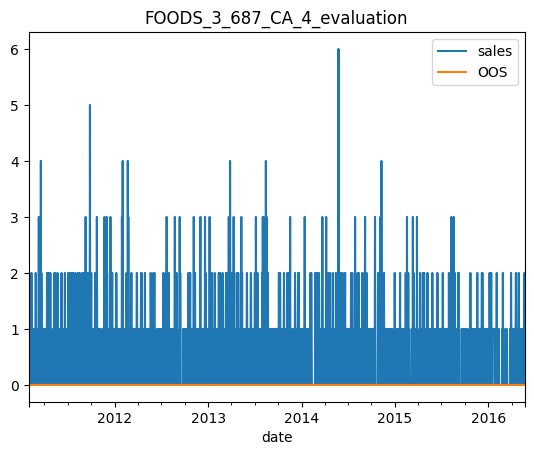

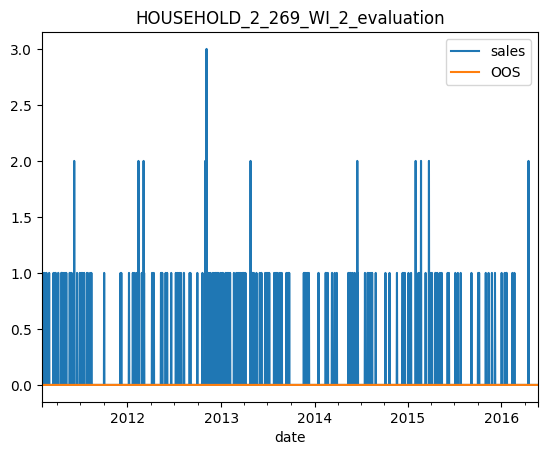

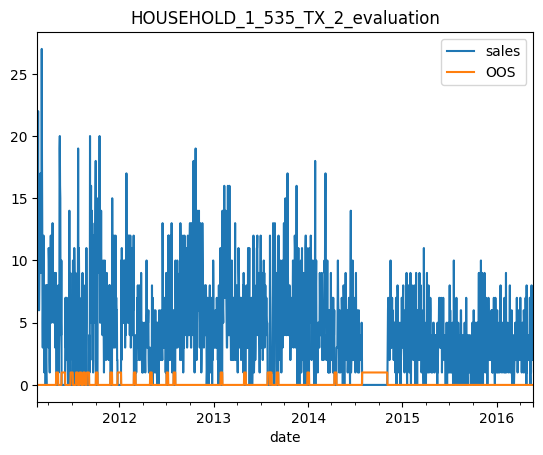

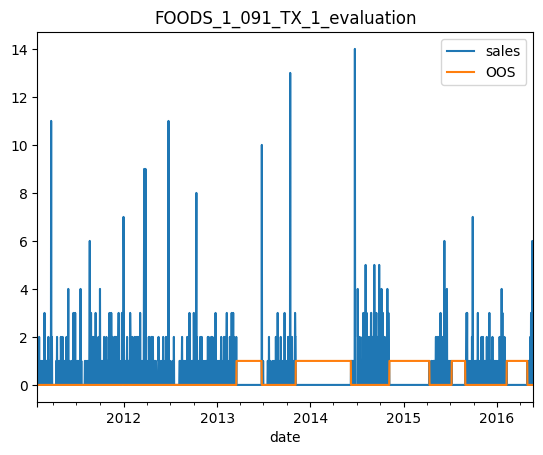

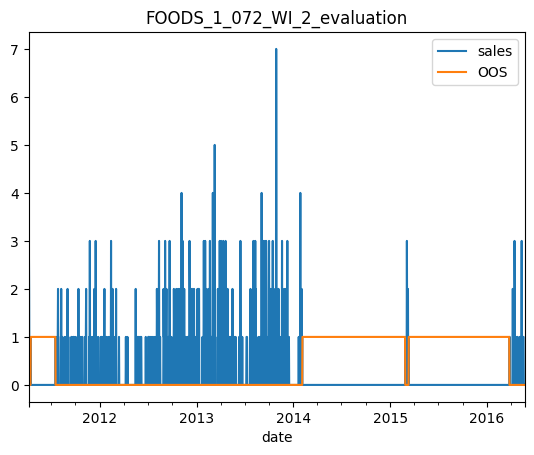

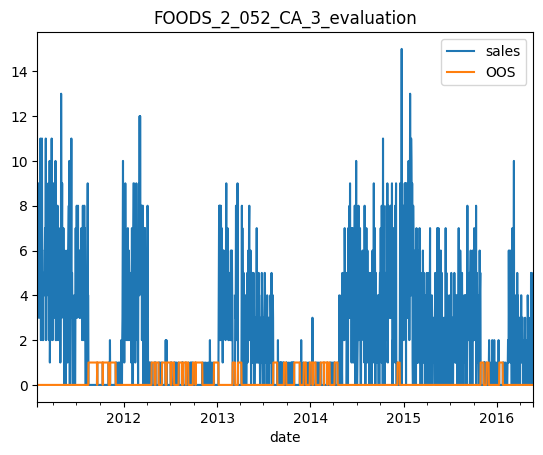

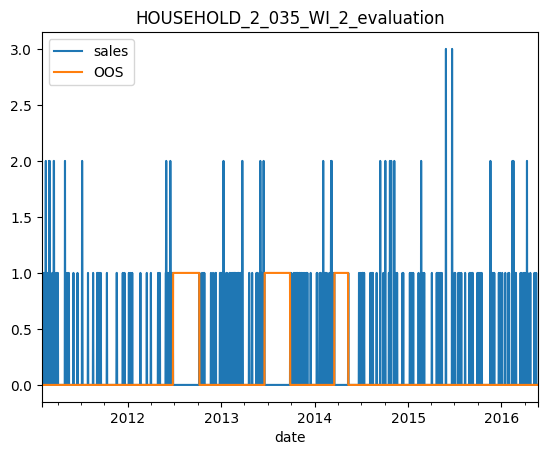

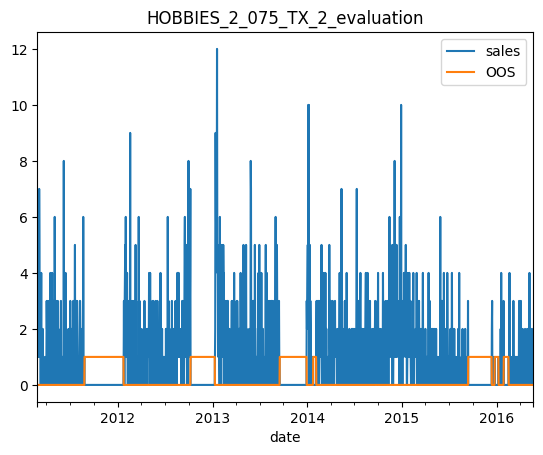

In [ ]:

join_1 = (
    df_zero_sales_period
    .join(df_zero_sales_period_aggregated, on=['id','zero_sales_period'])
    .select([pl.col('id'), pl.col('date'), pl.col('OOS')])
)

df_plot= (
    df_zero_ind 
    .join(# Join the calculated prob for the zero sales periods to 
            (  
                df_zero_sales_period
                .join(  # Join the calculated prob for the zero sales periods
                    df_zero_sales_period_aggregated
                    , on=['id','zero_sales_period']
                    )
                .select([pl.col('id'), pl.col('date'), pl.col('OOS')])
            )

            , on=['id', 'date'] 
            , how='left'
        )
    .with_columns(pl.col('OOS').fill_null(strategy="zero").alias('OOS'))
).collect()

# create new delta column calulated from zero sales indicator continues periods
#.select(pl.col('*'), (pl.col('zero_sales_ind')- pl.col('zero_sales_ind').shift(1)).alias('delta'))

# replace -1 with 0 otherwise delta column
#.select(pl.col('*').exclude('delta'), pl.when(pl.col('delta')==-1).then(0).otherwise(pl.col('delta')).alias('delta'))

# calculate cumulative sum of delta column multiplied by zero sales indicator to get zero sales periods
#.select(pl.col('*'),(pl.col('delta').cumsum() * pl.col('zero_sales_ind')).alias('zero_sales_period'))

# filter dataframe by zero sales indicator = 1 to get zero sales periods
#.filter(pl.col('zero_sales_ind')==1)
"""
sns.relplot(
    data=df_zero_sales_period.collect().to_pandas()
    , x='date'
    , y='zero_sales_period'
    , kind='line'
    , row='id'
    #, size='delta'
    , facet_kws={'sharey': False, 'sharex': False}
)

"""

for idx in list_of_ids:
    df_plot.filter(pl.col('id')==idx).to_pandas().plot(x='date', y=['sales','OOS'])
    plt.title(idx)


In [ ]:
df_plot

id,date,sales,zero_sales_ind,OOS
str,date,i16,i32,i32
"""FOODS_2_052_CA…",2011-01-29,3,0,0
"""FOODS_2_342_CA…",2011-01-29,1,0,0
"""FOODS_3_687_CA…",2011-01-29,1,0,0
"""FOODS_1_091_TX…",2011-01-29,1,0,0
"""HOUSEHOLD_2_03…",2011-01-29,1,0,0
"""FOODS_2_052_CA…",2011-01-30,6,0,0
"""FOODS_2_342_CA…",2011-01-30,3,0,0
"""FOODS_3_687_CA…",2011-01-30,0,1,0
"""FOODS_1_091_TX…",2011-01-30,0,1,0


In [ ]:
from timeit import default_timer as timer
from datetime import timedelta

start = timer()

# ....
# (your code runs here)
# ...

end = timer()
print(timedelta(seconds=end-start))


def calculate_out_of_stock_periods(df, list_of_ids = None, binomial_threshold = 0.001):
    """
    Calculate the probability that consecutive zero sales occur and classify  periods
    with a probability lower than the treshold as out of stock.

    Parameters:
    - df (polars.DataFrame): The input Polars DataFrame containing sales data.
    - list_of_ids (list): A list of IDs to filter the data. If None, all IDs are considered.
    - binomial_threshold (float, optional): The threshold for considering a period as out of stock.
      Defaults to 0.001.

    Returns:
    polars.LazyFrame: A lazy Polars DataFrame with information about zero sales periods and out of stock periods.

    Note: 
    The function assumes that 'pl' is an alias for the Polars library providing DataFrame operations.
    """
    start = timer()

    id_col, time_col, target_col = df.columns
    binomial_threshold = binomial_threshold

    # Creates a dataframe with zero sales indicator
    if list_of_ids is None:
        df_zero_ind = (df.lazy()
            .select(pl.col('*'), pl.when(pl.col(target_col) == 0).then(1).otherwise(0).alias('zero_sales_ind'))
        )

    else:
        df_zero_ind = (df.lazy()
            .filter(pl.col(id_col).is_in(list_of_ids))
            .select(pl.col('*'), pl.when(pl.col(target_col) == 0).then(1).otherwise(0).alias('zero_sales_ind'))
        )

    # Creates a dataframe with zero sales periods
    df_zero_sales_period = ( 
        df_zero_ind
        .sort([id_col, time_col])
        # Calculate delta column between zero sales datapoints to create distinct periods 
        .select(
            pl.col('*'),
            (
                pl.col('zero_sales_ind') -
                pl.col('zero_sales_ind').shift(1).over('id')).alias('delta')
        )
        # replace -1 with 0 because -1 is the same as 0 e.g a sales period 
        .select(
                pl.col('*').exclude('delta'),
                pl.when(pl.col('delta')==-1).then(0).otherwise(pl.col('delta')).alias('delta')
            )
        # cum_sum zero sales periods and index them starting from 1 to n periods with consecutive zeros
        .select(
                pl.col('*'),
                (pl.col('delta').cum_sum().over('id') * pl.col('zero_sales_ind')).alias('zero_sales_period')
            )
        .filter(pl.col('zero_sales_ind')==1)

    )

    # Create a dataframe with probability of zero sales based on total sales
    df_zero_sales_probability = (
        df_zero_ind.group_by(id_col)
        .agg(pl.col('zero_sales_ind')
        .mean().alias('prob_zero_sales'))
    )

    # evaluate the probabolity of zero sales in a row for each zero sales period
    df_zero_sales_period_aggregated =(
        df_zero_sales_period
        .group_by('id','zero_sales_period').agg(pl.col('zero_sales_ind').sum().alias('nbr_zero_sales_in_a_row')) 
        .join(df_zero_sales_probability, on=[id_col])
        .with_columns(
            pl.when(
                (
                    pl.col('prob_zero_sales') ** pl.col('nbr_zero_sales_in_a_row') * (1 - pl.col('prob_zero_sales')) ** (pl.col('nbr_zero_sales_in_a_row') - pl.col('nbr_zero_sales_in_a_row'))
                ) <= binomial_threshold
            ).then(1).otherwise(0).alias('OOS')
        )
    )


    # reconstruct the original dataframe
    join_1 = (
        df_zero_sales_period
        .join(df_zero_sales_period_aggregated, on=['id','zero_sales_period'])
        .select([pl.col('id'), pl.col('date'), pl.col('OOS')])
    )

    df_oss= (
        df_zero_ind 
        .join(# Join the calculated prob for the zero sales periods to the original dataframe
                (  
                    df_zero_sales_period
                    .join(  # Join the calculated prob for the zero sales periods
                        df_zero_sales_period_aggregated
                        , on=[id_col,'zero_sales_period']
                        )
                    .select([id_col, time_col, pl.col('OOS')])
                )

                , on=[id_col, time_col] 
                , how='left'
            )
        .with_columns(pl.col('OOS').fill_null(strategy="zero").alias('OOS'))
    ).collect()

    end = timer()
    print(timedelta(seconds=end-start))
    return df_oss



0:00:00.000014


In [ ]:
id_list = df.select(pl.col('id').unique()).sample(20000).to_series()

In [ ]:
df_oos = calculate_out_of_stock_periods(df, binomial_threshold=0.0001)

0:00:25.871658


In [ ]:
df_oos.select(pl.col('OOS').sum()/pl.col('zero_sales_ind').sum())

OOS
f64
0.27459


In [ ]:
df_oos.select(pl.col('OOS').sum()/pl.col('zero_sales_ind').sum())

OOS
f64
0.248203


In [ ]:
df_oos.write_parquet('df_point_of_sale_adj_oos.parquet')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0050dca7-17b3-44cb-a063-ab0f7808e424' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>